In [218]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import random
from math import radians, sin, cos, sqrt, asin
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [219]:
good_dir = Path(r'C:\Users\ajana\Downloads\Archive\Examples_ADSB_Good')

In [220]:
bad_dir =  Path(r'C:\Users\ajana\Downloads\Archive\Examples_ADSB_Bad')

In [221]:
good_files = sorted(good_dir.glob("*.npy"))
bad_files = sorted(bad_dir.glob("*.npy"))

In [222]:
good_trajectories = [np.load(f) for f in good_files]
bad_trajectories = [np.load(f) for f in bad_files]

In [223]:
print(f"Loaded {len(good_trajectories)} good and {len(bad_trajectories)} bad trajectories.")
print(f"Each trajectory shape: {good_trajectories[0].shape}")

Loaded 1000 good and 1000 bad trajectories.
Each trajectory shape: (20, 4)


In [224]:
columns = ["timestamp", "latitude", "longitude", "altitude_FL"]
example_good = good_trajectories[999]
example_bad = bad_trajectories[999]

In [225]:
print("Good example:")
display(pd.DataFrame(example_good, columns=columns).head())

print("Bad example:")
display(pd.DataFrame(example_bad, columns=columns).head())

Good example:


,timestamp,latitude,longitude,altitude_FL
0,1.646094e+09,51.0569,7.0168,1112.52
1,1.646094e+09,51.0563,7.0134,1097.28
2,1.646094e+09,51.0535,6.9997,1043.94
3,1.646094e+09,51.0520,6.9918,1005.84
4,1.646094e+09,51.0498,6.9815,960.12


Bad example:


,timestamp,latitude,longitude,altitude_FL
0,1.646093e+09,50.7890,5.5286,960.12
1,1.646093e+09,50.7888,5.6058,830.58
2,1.646093e+09,50.7888,5.6043,838.20
3,1.646093e+09,50.7406,5.6094,792.48
4,1.646093e+09,50.7888,5.6058,830.58


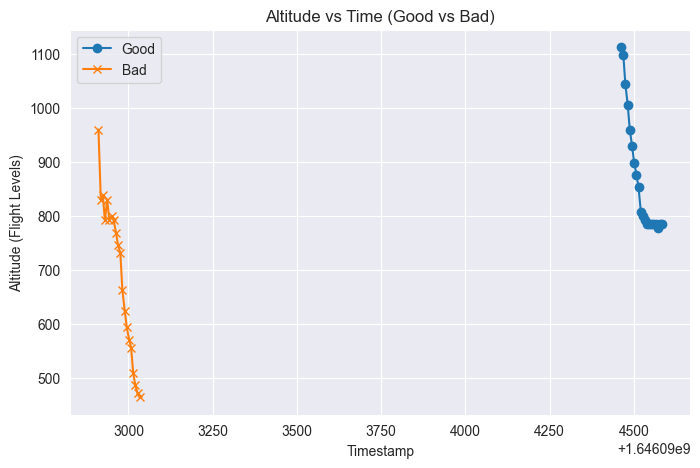

In [226]:
plt.figure(figsize=(8, 5))
plt.plot(example_good[:, 0], example_good[:, 3], 'o-', label='Good')
plt.plot(example_bad[:, 0], example_bad[:, 3], 'x-', label='Bad')
plt.xlabel("Timestamp")
plt.ylabel("Altitude (Flight Levels)")
plt.title("Altitude vs Time (Good vs Bad)")
plt.legend()
plt.grid(True)
plt.show()

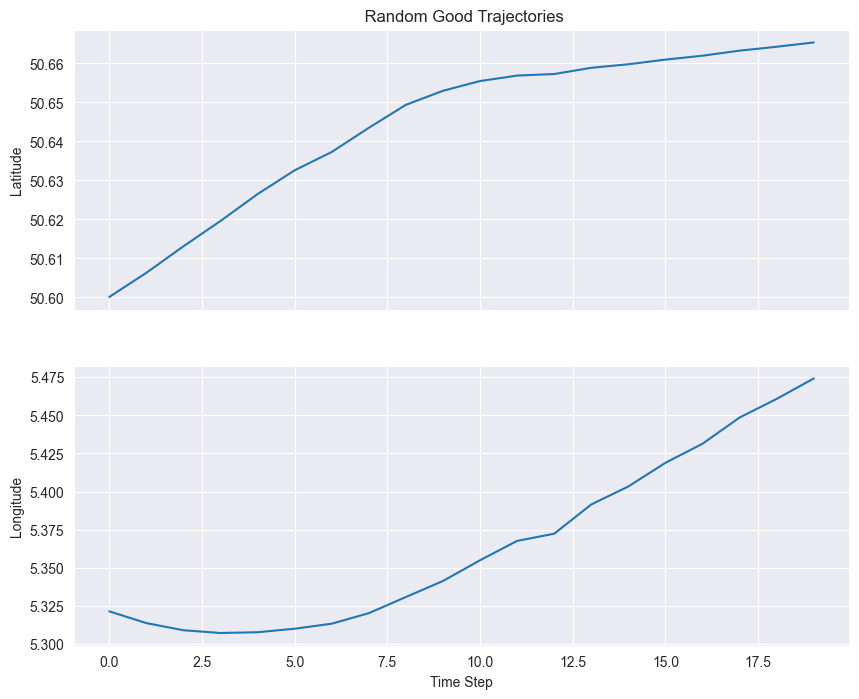

In [227]:
plt.show()
num_to_plot = 1
samples = random.sample(good_trajectories, num_to_plot)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for traj in samples:
    time = range(len(traj))
    axes[0].plot(time, traj[:, 1], color='tab:blue')
    axes[1].plot(time, traj[:, 2], color='tab:blue')

axes[0].set_ylabel("Latitude")
axes[0].set_title(f" Random Good Trajectories")

axes[1].set_ylabel("Longitude")
axes[1].set_xlabel("Time Step")

for ax in axes:
    ax.grid(True)

plt.show()


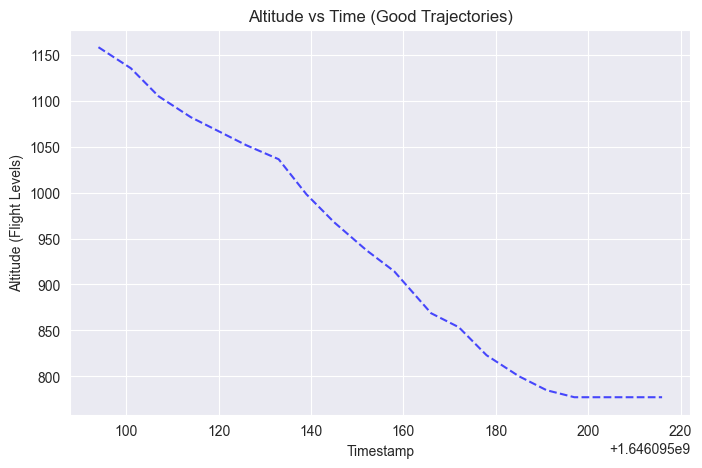

In [228]:
plt.figure(figsize=(8, 5))
for traj in random.sample(good_trajectories, 1):
    plt.plot(traj[:, 0], traj[:, 3], 'b--', alpha=0.7)

plt.title("Altitude vs Time (Good Trajectories)")
plt.xlabel("Timestamp")
plt.ylabel("Altitude (Flight Levels)")
plt.grid(True)
plt.show()

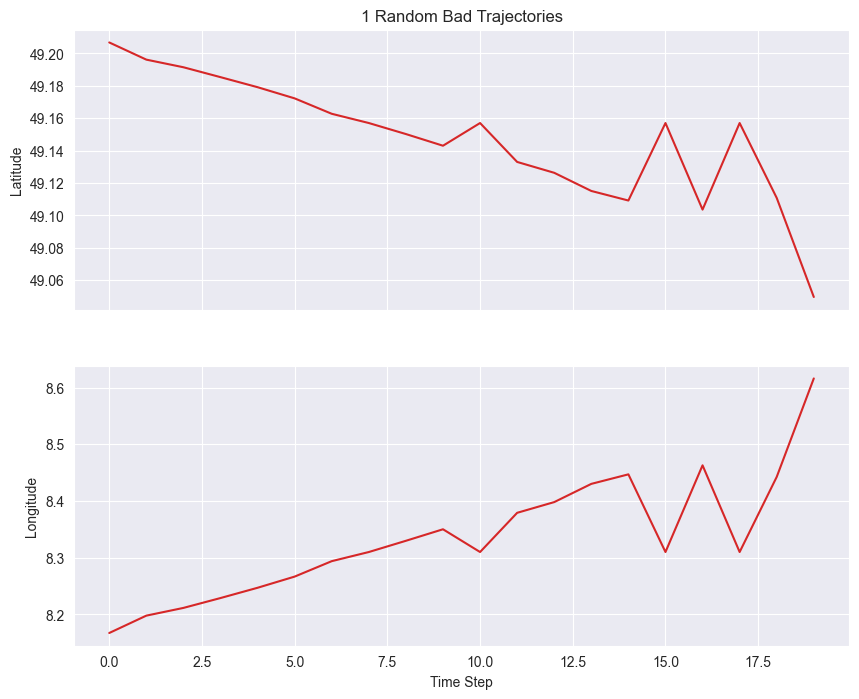

In [229]:
plt.show()
num_to_plot = 1
samples = random.sample(bad_trajectories, num_to_plot)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for traj in samples:
    time = range(len(traj))
    axes[0].plot(time, traj[:, 1], color='tab:red')
    axes[1].plot(time, traj[:, 2], color='tab:red')

axes[0].set_ylabel("Latitude")
axes[0].set_title(f"{num_to_plot} Random Bad Trajectories")

axes[1].set_ylabel("Longitude")
axes[1].set_xlabel("Time Step")

for ax in axes:
    ax.grid(True)

plt.show()

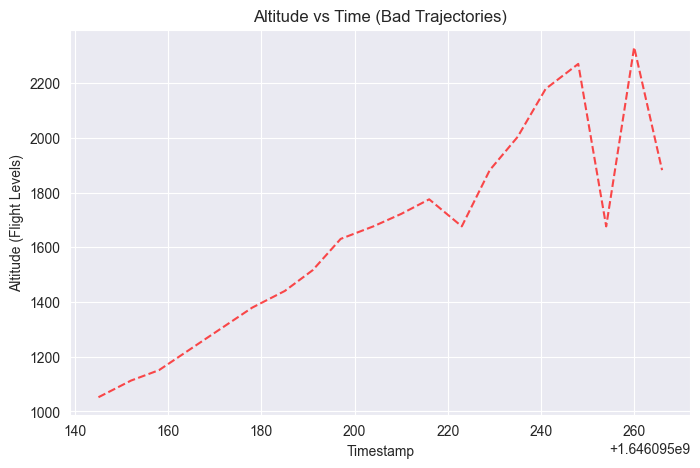

In [230]:
plt.figure(figsize=(8, 5))
for traj in random.sample(bad_trajectories, 1):
    plt.plot(traj[:, 0], traj[:, 3], 'r--', alpha=0.7)

plt.title("Altitude vs Time (Bad Trajectories)")
plt.xlabel("Timestamp")
plt.ylabel("Altitude (Flight Levels)")
plt.grid(True)
plt.show()

In [231]:
#Function that will help me with calculating the distance between two points in a trajectory
#using Haversine distance calculated in meters(m)
def haversine_m(lat1, lon1, lat2, lon2):
    try:
        R = 6371000.0
        phi1, phi2 = map(radians, (lat1, lat2))
        dphi = radians(lat2 - lat1)
        dlambda = radians(lon2 - lon1)
        a = sin(dphi/2)**2 + cos(phi1)*cos(phi2)*sin(dlambda/2)**2
        return 2 * R * asin(min(1, sqrt(a)))
    except:
        return 0.0

In [232]:
#Function that returns a dataframe with imputed distance, time difference, horizontal speed and vertical rate in every row (between every consecutive point)
def pointwise(traj):
    #Return DataFrame with ts,lat,lon,alt_FL,dt,dist_m,speed_m_s,vertical_rate_FL_s
    df = pd.DataFrame(traj, columns=['t','lat','lon','alt_FL']).astype(float)
    df['dt'] = df['t'].diff().fillna(1.0)
    # distances
    dists = [0.0]
    for i in range(1, len(df)):
        dists.append(haversine_m(df.loc[i-1,'lat'], df.loc[i-1,'lon'],
                                 df.loc[i,'lat'], df.loc[i,'lon']))
    df['dist_m'] = dists
    # speeds
    df['speed_m_s'] = df['dist_m'] / df['dt'].replace(0, np.nan)
    df['speed_m_s'] = df['speed_m_s'].fillna(0.0)
    # vertical rate
    df['vertical_rate_FL_s'] = df['alt_FL'].diff() / df['dt'].replace(0, np.nan)
    df['vertical_rate_FL_s'] = df['vertical_rate_FL_s'].fillna(0.0)
    return df

In [233]:
df_example_1 = pointwise(example_good)
display(df_example_1.head())

,t,lat,lon,alt_FL,dt,dist_m,speed_m_s,vertical_rate_FL_s
0,1.646094e+09,51.0569,7.0168,1112.52,1.0,0.000000,0.000000,0.000000
1,1.646094e+09,51.0563,7.0134,1097.28,6.0,246.820246,41.136708,-2.540000
2,1.646094e+09,51.0535,6.9997,1043.94,6.0,1006.898465,167.816411,-8.890000
3,1.646094e+09,51.0520,6.9918,1005.84,7.0,576.831908,82.404558,-5.442857
4,1.646094e+09,51.0498,6.9815,960.12,6.0,760.398957,126.733160,-7.620000


In [234]:
df_example_2 = pointwise(example_bad)
display(df_example_2.head())

,t,lat,lon,alt_FL,dt,dist_m,speed_m_s,vertical_rate_FL_s
0,1.646093e+09,50.7890,5.5286,960.12,1.0,0.000000,0.000000,0.000000
1,1.646093e+09,50.7888,5.6058,830.58,7.0,5426.830473,775.261496,-18.505714
2,1.646093e+09,50.7888,5.6043,838.20,6.0,105.442942,17.573824,1.270000
3,1.646093e+09,50.7406,5.6094,792.48,6.0,5371.584737,895.264123,-7.620000
4,1.646093e+09,50.7888,5.6058,830.58,7.0,5365.572706,766.510387,5.442857


In [235]:
#Function that returns a trajectory with calculated features that I think are important to help me build a model for detecting bad trajectories.

def summarize(traj):
    df = pointwise(traj)
    feats = {}
    feats['mean_speed_m_s'] = float(df['speed_m_s'].mean())
    feats['std_speed_m_s'] = float(df['speed_m_s'].std())
    feats['max_speed_m_s'] = float(df['speed_m_s'].max())
    feats['mean_vrate'] = float(df['vertical_rate_FL_s'].mean())
    feats['max_abs_vrate'] = float(np.abs(df['vertical_rate_FL_s']).max())
    feats['total_dist_m'] = float(df['dist_m'].sum())
    feats['sinuosity'] = feats['total_dist_m'] / haversine_m(df.loc[0,'lat'], df.loc[0,'lon'], df.loc[len(df)-1,'lat'], df.loc[len(df)-1,'lon'])
    feats['frac_zero_speed'] = float((df['speed_m_s'] == 0).mean())
    feats['n_large_alt_jumps'] = int((df['alt_FL'].diff().abs() > 50).sum())
    return feats

In [236]:
print(summarize(example_good))

{'mean_speed_m_s': 91.92922203674634, 'std_speed_m_s': 41.175087148845726, 'max_speed_m_s': 167.81641075581803, 'mean_vrate': -2.576285714285714, 'max_abs_vrate': 8.889999999999986, 'total_dist_m': 11672.330151717395, 'sinuosity': 1.4788539917853456, 'frac_zero_speed': 0.05, 'n_large_alt_jumps': 1}


In [237]:
print(summarize(example_bad))

{'mean_speed_m_s': 223.19408541103684, 'std_speed_m_s': 329.8297152764309, 'max_speed_m_s': 993.0177384786898, 'mean_vrate': -3.8916428571428563, 'max_abs_vrate': 18.50571428571428, 'total_dist_m': 28681.36518643922, 'sinuosity': 2.7383240111439204, 'frac_zero_speed': 0.05, 'n_large_alt_jumps': 2}


In [238]:
# Simple comparison of the features of a good and bad trajectory
def compare(good_traj, bad_traj):
    good_feats = summarize(good_traj)
    bad_feats = summarize(bad_traj)

    print(f"{'Feature':25s} {'Good':>10s} {'Bad':>10s} {'Diff':>10s}")
    print("-"*60)
    for key in good_feats.keys():
        g = good_feats[key]
        b = bad_feats[key]
        diff = b - g
        print(f"{key:25s} {g:10.2f} {b:10.2f} {diff:10.2f}")

In [239]:
compare(good_trajectories[1], bad_trajectories[1])

Feature                         Good        Bad       Diff
------------------------------------------------------------
mean_speed_m_s                123.16     762.92     639.76
std_speed_m_s                  89.42    1182.45    1093.03
max_speed_m_s                 323.34    3818.81    3495.47
mean_vrate                     13.42      -0.06     -13.48
max_abs_vrate                  35.56       1.27     -34.29
total_dist_m                15527.50   97191.39   81663.89
sinuosity                       1.03       1.73       0.70
frac_zero_speed                 0.05       0.05       0.00
n_large_alt_jumps              15.00       0.00     -15.00


In [240]:
# Here I start building the dataset with good and bad data
features_list = []
labels = []

# Good trajectories: label = 1
for traj in good_trajectories:
    feats = summarize(traj)
    features_list.append(feats)
    labels.append(1)

# Bad trajectories: label = 0
for traj in bad_trajectories:
    feats = summarize(traj)
    features_list.append(feats)
    labels.append(0)

In [241]:
#Data frame
df_features = pd.DataFrame(features_list)
df_features['label'] = labels

display(df_features.head())

,mean_speed_m_s,std_speed_m_s,max_speed_m_s,mean_vrate,max_abs_vrate,total_dist_m,sinuosity,frac_zero_speed,n_large_alt_jumps,label
0,103.234311,48.480439,223.112172,9.325429,25.400000,13003.308404,1.366544,0.05,13,1
1,123.159470,89.422469,323.339968,13.416643,35.560000,15527.503119,1.032335,0.05,15,1
2,105.181160,47.991512,183.490693,-3.075214,8.708571,13277.711806,1.074209,0.05,1,1
3,106.704117,42.368699,187.648343,-4.553857,16.328571,13610.997135,1.101994,0.05,4,1
4,68.541010,31.580023,131.603336,-0.045357,1.270000,8687.769118,1.297803,0.05,0,1


In [242]:
# I shuffled the data in the dataset so it is more diverse
df_features = df_features.sample(frac=1, random_state=42).reset_index(drop=True)
display(df_features.head())

,mean_speed_m_s,std_speed_m_s,max_speed_m_s,mean_vrate,max_abs_vrate,total_dist_m,sinuosity,frac_zero_speed,n_large_alt_jumps,label
0,230.757091,251.929412,1186.203620,8.277679,73.66,28808.987276,2.719781,0.05,17,0
1,86.981668,46.004122,174.002315,-2.467429,10.16,10881.678682,1.141795,0.05,3,1
2,579.040031,978.270685,3193.929743,0.054429,1.27,72909.720905,1.879839,0.05,0,0
3,22.785404,19.565986,86.936458,-0.426357,2.54,2901.250954,1.060240,0.05,0,1
4,642.592071,1001.183172,3234.611985,-9.597571,78.74,81923.961598,1.740203,0.05,5,0


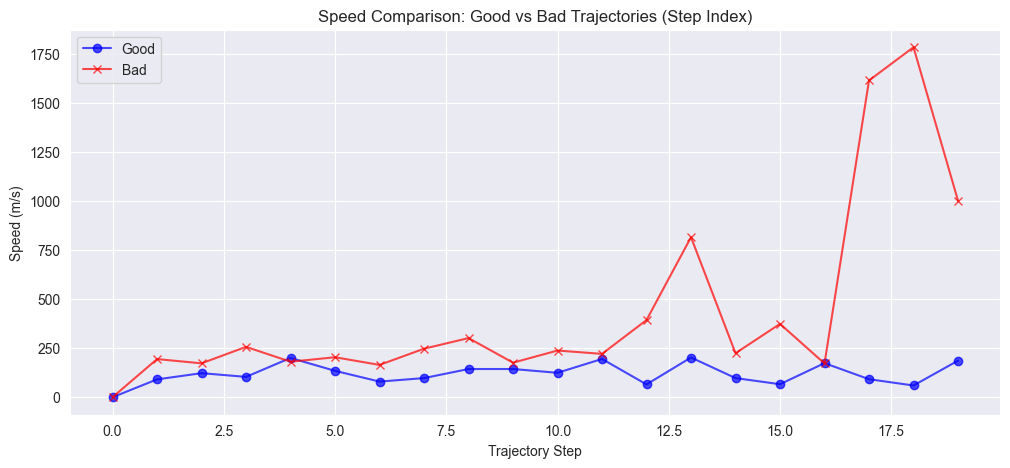

In [243]:
# Visualisation of the speed for a good vs a bad trajectory over time.
def plot_speed_over_steps(good_traj, bad_traj, label_good="Good", label_bad="Bad"):
    df_good = pointwise(good_traj)
    df_bad = pointwise(bad_traj)

    plt.figure(figsize=(12,5))

    # Step indices
    steps_good = range(len(df_good))
    steps_bad = range(len(df_bad))

    plt.plot(steps_good, df_good['speed_m_s'], '-o', color='blue', alpha=0.7, label=label_good)
    plt.plot(steps_bad, df_bad['speed_m_s'], '-x', color='red', alpha=0.7, label=label_bad)

    plt.xlabel("Trajectory Step")
    plt.ylabel("Speed (m/s)")
    plt.title("Speed Comparison: Good vs Bad Trajectories (Step Index)")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_speed_over_steps(good_trajectories[186], bad_trajectories[786])


In [244]:
# Building the model
X = df_features.drop(columns=['label'])
y = df_features['label']

In [245]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

Train samples: 1600, Test samples: 400


In [246]:
rf = RandomForestClassifier(
    n_estimators=300,      # number of trees
    max_depth=None,        # let the trees grow fully
    random_state=42,
    n_jobs=-1              # use all CPU cores
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [247]:
# Predictions
y_pred = rf.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9925

Confusion Matrix:
 [[198   2]
 [  1 199]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       200
           1       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



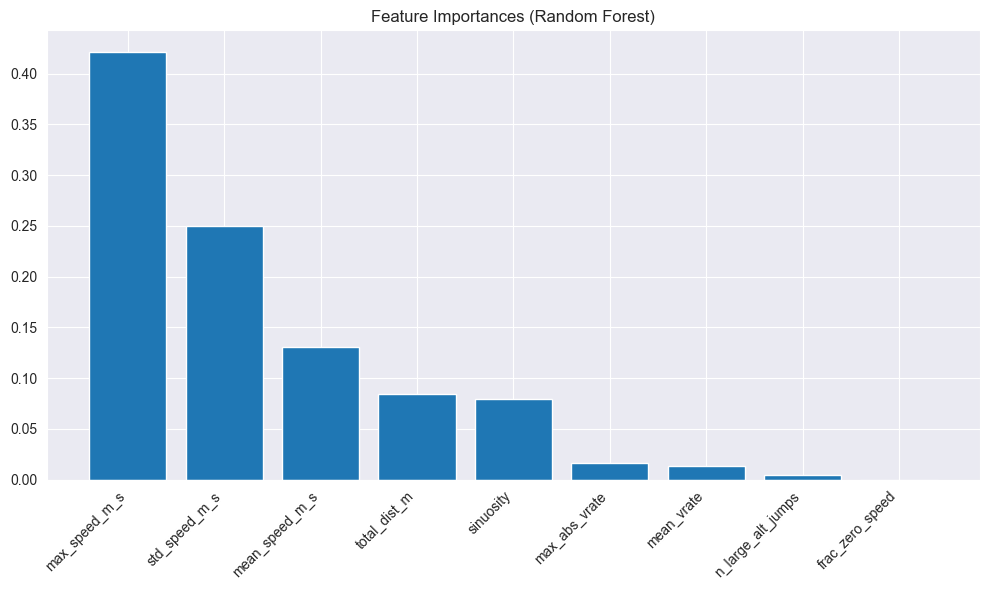

In [248]:
# Visual representation of the importance of different features
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), importances[indices], align='center')
plt.xticks(range(len(features)), features[indices], rotation=45, ha='right')
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

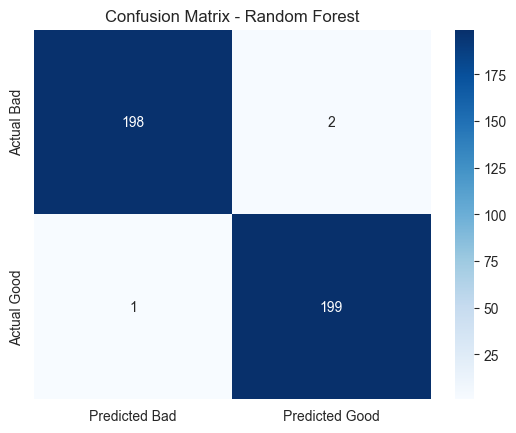

In [249]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Bad", "Predicted Good"],
            yticklabels=["Actual Bad", "Actual Good"])
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [250]:
# Dropping the two less-useful features
X = df_features.drop(columns=['label', 'frac_zero_speed', 'n_large_alt_jumps'])
y = df_features['label']

print("Using these features for training:")
print(X.columns.tolist())
print(f"\nShape of feature matrix: {X.shape}")

Using these features for training:
['mean_speed_m_s', 'std_speed_m_s', 'max_speed_m_s', 'mean_vrate', 'max_abs_vrate', 'total_dist_m', 'sinuosity']

Shape of feature matrix: (2000, 7)


In [251]:
# Building a new model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [252]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [253]:
y_pred = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9950

Confusion Matrix:
 [[198   2]
 [  0 200]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       200
           1       0.99      1.00      1.00       200

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400



In [254]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy', n_jobs=-1)

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation: {:.4f}".format(cv_scores.std()))

Cross-validation scores: [0.9975 0.9925 1.     0.99   0.9975]
Mean CV accuracy: 0.9955
Standard deviation: 0.0037


In [255]:
# Calculating the upper limit of the range for normal trajectories for every feature
df_good = df_features[df_features['label'] == 1].drop(columns='label')

# Calculate upper limits (mean + 2*std)
upper_limits = pd.Series(index=df_good.columns, dtype=float)

for col in df_good.columns:
    mean_val = df_good[col].mean()
    std_val = df_good[col].std()
    upper_limits[col] = mean_val + 2*std_val

upper_limits = upper_limits.round(2)

display(upper_limits)

mean_speed_m_s         204.70
std_speed_m_s          165.62
max_speed_m_s          754.05
mean_vrate              15.78
max_abs_vrate           44.34
total_dist_m         26011.95
sinuosity                2.89
frac_zero_speed          0.05
n_large_alt_jumps       18.69
dtype: float64

In [256]:
# Calculate the lower limit for total_dist_m for good trajectories
df_good = df_features[df_features['label'] == 1].drop(columns='label')

mean_dist = df_good['total_dist_m'].mean()
std_dist = df_good['total_dist_m'].std()

# Lower limit (mean - 2*std)
lower_limit_dist = max(0, mean_dist - 2 * std_dist)
print(lower_limit_dist)

1663.7057171684974


In [257]:
#Analyzes a trajectory and explains potential problems based on learned model features
def explain_trajectory(traj, model, thresholds=None):
    feats = summarize(traj)

    feats = {k: v for k, v in feats.items() if k not in ['frac_zero_speed', 'n_large_alt_jumps']}

    X_sample = pd.DataFrame([feats])

    pred = model.predict(X_sample)[0]
    print("Trajectory Analysis")
    print("-------------------------")
    print(f"Predicted label: {'GOOD' if pred==1 else 'BAD'}")

    issues = []
    if feats['max_speed_m_s'] > 754:
        issues.append("Extremely high max speed (possible GPS spike)")
    if feats['std_speed_m_s'] > 165:
        issues.append("Large speed variation (unstable trajectory)")
    if feats['sinuosity'] > 2.89:
        issues.append("Path is too curved or inconsistent")
    if abs(feats['mean_vrate']) > 15:
        issues.append("Excessive vertical rate (possible altitude jumps)")
    if feats['total_dist_m'] < 1664:
        issues.append("Very short movement distance (possible incomplete track)")
    if feats['total_dist_m'] > 26000:
        issues.append("Very long movement distance")

    if issues:
        print("Potential Issues:")
        for i in issues:
            print(" -", i)
    else:
        print("Trajectory appears smooth and consistent.")


In [258]:
# Testing the function
print("Example GOOD trajectory:")
explain_trajectory(good_trajectories[10], rf)

Example GOOD trajectory:
Trajectory Analysis
-------------------------
Predicted label: GOOD
Trajectory appears smooth and consistent.


In [259]:
print("\nExample BAD trajectory:")
explain_trajectory(bad_trajectories[155], rf)


Example BAD trajectory:
Trajectory Analysis
-------------------------
Predicted label: BAD
Potential Issues:
 - Extremely high max speed (possible GPS spike)
 - Large speed variation (unstable trajectory)
 - Very long movement distance


Optimizing bad trajectories aggressively

In [260]:
# Removing velocity outliers
def remove_velocity_outliers(df, max_speed):

    if len(df) < 2:
        return df

    # Calculating speed for every segment
    high_speed_mask = [False]  # first point

    for i in range(1, len(df)):
        dist = haversine_m(df.loc[i-1, 'lat'], df.loc[i-1, 'lon'],
                          df.loc[i, 'lat'], df.loc[i, 'lon'])
        time_diff = df.loc[i, 'timestamp'] - df.loc[i-1, 'timestamp']
        speed = dist / time_diff if time_diff > 0 else 0
        high_speed_mask.append(speed > max_speed)

    # print(f"Removed {sum(high_speed_mask)} points with speed > {max_speed} m/s")

    high_speed_mask = np.array(high_speed_mask)
    return df[~high_speed_mask].reset_index(drop=True)


In [261]:
# Removing spatial outliers
def remove_spatial_outliers(df, max_jump_km):

    if len(df) < 2:
        return df

    large_jump_mask = [False]

    for i in range(1, len(df)):
        dist = haversine_m(df.loc[i-1, 'lat'], df.loc[i-1, 'lon'],
                          df.loc[i, 'lat'], df.loc[i, 'lon'])
        max_jump_m = max_jump_km * 1000
        large_jump_mask.append(dist > max_jump_m)

    # print(f"Removed {sum(large_jump_mask)} points with spatial jumps > {max_jump_km}km")

    large_jump_mask = np.array(large_jump_mask)
    return df[~large_jump_mask].reset_index(drop=True)

In [262]:
# Reducing the number of points with smart sampling
def smart_sampling(df, max_points):
    if len(df) <= max_points:
        return df

    # Using indices for balanced sampling
    indices = np.linspace(0, len(df)-1, max_points, dtype=int)
    return df.iloc[indices].reset_index(drop=True)

In [285]:
# Optimizing the trajectory to reduce curvature by removing points that cause sharp turns and backtracking
def optimize_sinuosity(df, max_sinuosity):

    if len(df) < 4:
        return df

    # Current sinuosity
    direct_distance = haversine_m(df.iloc[0]['lat'], df.iloc[0]['lon'],
                                 df.iloc[-1]['lat'], df.iloc[-1]['lon'])

    # All points at same location, skipping sinuosity optimization
    if direct_distance == 0:
        return df

    total_distance = sum([haversine_m(df.iloc[i-1]['lat'], df.iloc[i-1]['lon'],
                                     df.iloc[i]['lat'], df.iloc[i]['lon'])
                         for i in range(1, len(df))])

    current_sinuosity = total_distance / direct_distance if direct_distance > 0 else 1.0

    if current_sinuosity <= max_sinuosity:
        return df

    # print(f"Sinuosity before optimization: {current_sinuosity:.2f}")

    # Algorithm to reduce sinuosity
    keep_mask = [True] * len(df)

    # First and last points
    keep_mask[0] = True
    keep_mask[-1] = True

    for i in range(1, len(df)-1):
        vec1_lat = df.iloc[i]['lat'] - df.iloc[i-1]['lat']
        vec1_lon = df.iloc[i]['lon'] - df.iloc[i-1]['lon']

        vec2_lat = df.iloc[i+1]['lat'] - df.iloc[i]['lat']
        vec2_lon = df.iloc[i+1]['lon'] - df.iloc[i]['lon']

        # Angle between vectors
        dot_product = vec1_lat * vec2_lat + vec1_lon * vec2_lon
        mag1 = np.sqrt(vec1_lat**2 + vec1_lon**2)
        mag2 = np.sqrt(vec2_lat**2 + vec2_lon**2)

        if mag1 > 0 and mag2 > 0:
            cosine_angle = dot_product / (mag1 * mag2)
            # Limiting value to [-1, 1] due to floating point errors
            cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
            angle = np.arccos(cosine_angle)

            # Sharp angle = backtracking
            if angle > np.radians(135):
                keep_mask[i] = False
                # print(f"Removed point {i} with angle {np.degrees(angle):.1f}° (backtracking)")
        else:
            # If zero magnitude, it's not causing backtracking
            keep_mask[i] = True

    df_optimized = df[keep_mask].reset_index(drop=True)

    # New sinuosity
    new_direct_distance = haversine_m(df_optimized.iloc[0]['lat'], df_optimized.iloc[0]['lon'], df_optimized.iloc[-1]['lat'], df_optimized.iloc[-1]['lon'])

    new_total_distance = sum([haversine_m(df_optimized.iloc[i-1]['lat'], df_optimized.iloc[i-1]['lon'], df_optimized.iloc[i]['lat'], df_optimized.iloc[i]['lon'])
                             for i in range(1, len(df_optimized))])

    new_sinuosity = new_total_distance / new_direct_distance if new_direct_distance > 0 else 1.0

    # print(f"Sinuosity after optimization: {new_sinuosity:.2f}")
    # print(f"Points: {len(df)} → {len(df_optimized)}")

    return df_optimized

In [286]:
# Aggressive optimization using fixed thresholds
def optimize_trajectory_aggressive(trajectory):
    df = pd.DataFrame(trajectory, columns=['timestamp', 'lat', 'lon', 'alt_FL'])

    # print(f"Original: {len(df)} points")

    # Sort and clean
    df = df.sort_values('timestamp').reset_index(drop=True)
    df = df.drop_duplicates(subset=['timestamp'])

    # Removing GPS spikes based on the speed (>300 m/s ~ 1080 km/h)
    df = remove_velocity_outliers(df, max_speed=300)

    # Removing spatial outliers (big jumps/gaps)
    df = remove_spatial_outliers(df, max_jump_km=10)

    # Sampling if many points are removed
    if len(df) > 50:
        df = smart_sampling(df, max_points=30)

    if len(df) > 8:
        df = optimize_sinuosity(df, max_sinuosity=1.5)

    # print(f"Optimized: {len(df)} points")
    return df.values


In [265]:
print("--- AGGRESSIVE OPTIMIZATION ---")
optimized_aggressive = optimize_trajectory_aggressive(bad_trajectories[10])

print("\n--- RE-EVALUATION ---")
explain_trajectory(optimized_aggressive, rf)

print("\n--- MODEL PREDICTION ---")
feats_opt = summarize(optimized_aggressive)
feats_filtered = {k: v for k, v in feats_opt.items()
                 if k not in ['frac_zero_speed', 'n_large_alt_jumps']}

X_opt = pd.DataFrame([feats_filtered])
pred_opt = rf.predict(X_opt)[0]
proba_opt = rf.predict_proba(X_opt)[0]

print(f"Predicted class: {'GOOD' if pred_opt == 1 else 'BAD'}")
print(f"Probability: {proba_opt}")

--- AGGRESSIVE OPTIMIZATION ---

--- RE-EVALUATION ---
Trajectory Analysis
-------------------------
Predicted label: GOOD
Trajectory appears smooth and consistent.

--- MODEL PREDICTION ---
Predicted class: GOOD
Probability: [0.00666667 0.99333333]


In [288]:
# Visualisation on original and optimized trajectory
def compare_trajectories_detailed(original, optimized, original_label="Original (Bad)", optimized_label="Optimized (Good)"):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Conversion to dataframe
    df_orig = pd.DataFrame(original, columns=['timestamp', 'lat', 'lon', 'alt_FL'])
    df_opt = pd.DataFrame(optimized, columns=['timestamp', 'lat', 'lon', 'alt_FL'])

    # Sort by timestamp
    df_orig = df_orig.sort_values('timestamp')
    df_opt = df_opt.sort_values('timestamp')

    # Altitude vs Timestamp
    axes[0,0].plot(df_orig['timestamp'], df_orig['alt_FL'], 'ro-', alpha=0.7, label=original_label, markersize=6)
    axes[0,0].plot(df_opt['timestamp'], df_opt['alt_FL'], 'go-', alpha=0.7, label=optimized_label, markersize=6)
    axes[0,0].set_xlabel('Times')
    axes[0,0].set_ylabel('Altitude (FL)')
    axes[0,0].set_title('Altitude vs Time')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Lat vs Long (2D trajectory)
    axes[0,1].plot(df_orig['lon'], df_orig['lat'], 'ro-', alpha=0.7, label=original_label, markersize=6)
    axes[0,1].plot(df_opt['lon'], df_opt['lat'], 'go-', alpha=0.7, label=optimized_label, markersize=6)
    axes[0,1].set_xlabel('Longitude')
    axes[0,1].set_ylabel('Latitude')
    axes[0,1].set_title('2D Trajectory (Lat-Lon)')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Speed over time
    def calculate_speeds(df):
        speeds = [0]
        for i in range(1, len(df)):
            dist = haversine_m(df.iloc[i-1]['lat'], df.iloc[i-1]['lon'],
                              df.iloc[i]['lat'], df.iloc[i]['lon'])
            time_diff = df.iloc[i]['timestamp'] - df.iloc[i-1]['timestamp']
            speed = dist / time_diff if time_diff > 0 else 0
            speeds.append(speed)
        return speeds

    orig_speeds = calculate_speeds(df_orig)
    opt_speeds = calculate_speeds(df_opt)

    axes[0,2].plot(range(len(orig_speeds)), orig_speeds, 'ro-', alpha=0.7, label=original_label)
    axes[0,2].plot(range(len(opt_speeds)), opt_speeds, 'go-', alpha=0.7, label=optimized_label)
    axes[0,2].axhline(y=300, color='r', linestyle='--', alpha=0.5, label='Speed limit (300 m/s)')
    axes[0,2].set_xlabel('Point index')
    axes[0,2].set_ylabel('Speed (m/s)')
    axes[0,2].set_title('Speed per point')
    axes[0,2].legend()
    axes[0,2].grid(True)

    # Speed histogram
    axes[1,0].hist(orig_speeds, bins=10, alpha=0.7, color='red', label=original_label)
    axes[1,0].hist(opt_speeds, bins=10, alpha=0.7, color='green', label=optimized_label)
    axes[1,0].axvline(x=300, color='r', linestyle='--', alpha=0.5, label='Speed limit')
    axes[1,0].set_xlabel('Speed (m/s)')
    axes[1,0].set_ylabel('Number of points')
    axes[1,0].set_title('Speed distribution')
    axes[1,0].legend()
    axes[1,0].grid(True)

    # Time differences
    orig_time_diffs = df_orig['timestamp'].diff().dropna()
    opt_time_diffs = df_opt['timestamp'].diff().dropna()

    axes[1,1].plot(range(len(orig_time_diffs)), orig_time_diffs, 'ro-', alpha=0.7, label=original_label)
    axes[1,1].plot(range(len(opt_time_diffs)), opt_time_diffs, 'go-', alpha=0.7, label=optimized_label)
    axes[1,1].set_xlabel('Segment index')
    axes[1,1].set_ylabel('Time difference (s)')
    axes[1,1].set_title('Time intervals')
    axes[1,1].legend()
    axes[1,1].grid(True)

    # Feature comparison
    features_orig = summarize(original)
    features_opt = summarize(optimized)

    comparison_features = ['mean_speed_m_s', 'max_speed_m_s', 'std_speed_m_s', 'sinuosity']
    orig_values = [features_orig[f] for f in comparison_features]
    opt_values = [features_opt[f] for f in comparison_features]

    x_pos = np.arange(len(comparison_features))
    width = 0.35

    axes[1,2].bar(x_pos - width/2, orig_values, width, alpha=0.7, color='red', label=original_label)
    axes[1,2].bar(x_pos + width/2, opt_values, width, alpha=0.7, color='green', label=optimized_label)
    axes[1,2].set_xlabel('Features')
    axes[1,2].set_ylabel('Values')
    axes[1,2].set_title('Feature comparison')
    axes[1,2].set_xticks(x_pos)
    axes[1,2].set_xticklabels(comparison_features, rotation=45)
    axes[1,2].legend()
    axes[1,2].grid(True)

    plt.tight_layout()
    plt.show()

    print("=== COMPARISON STATISTICS ===")
    print(f"Original trajectory: {len(original)} points")
    print(f"Optimized trajectory: {len(optimized)} points")
    print(f"Removed: {len(original) - len(optimized)} points")
    print(f"Maximum speed (original): {max(orig_speeds):.2f} m/s")
    print(f"Maximum speed (optimized): {max(opt_speeds):.2f} m/s")


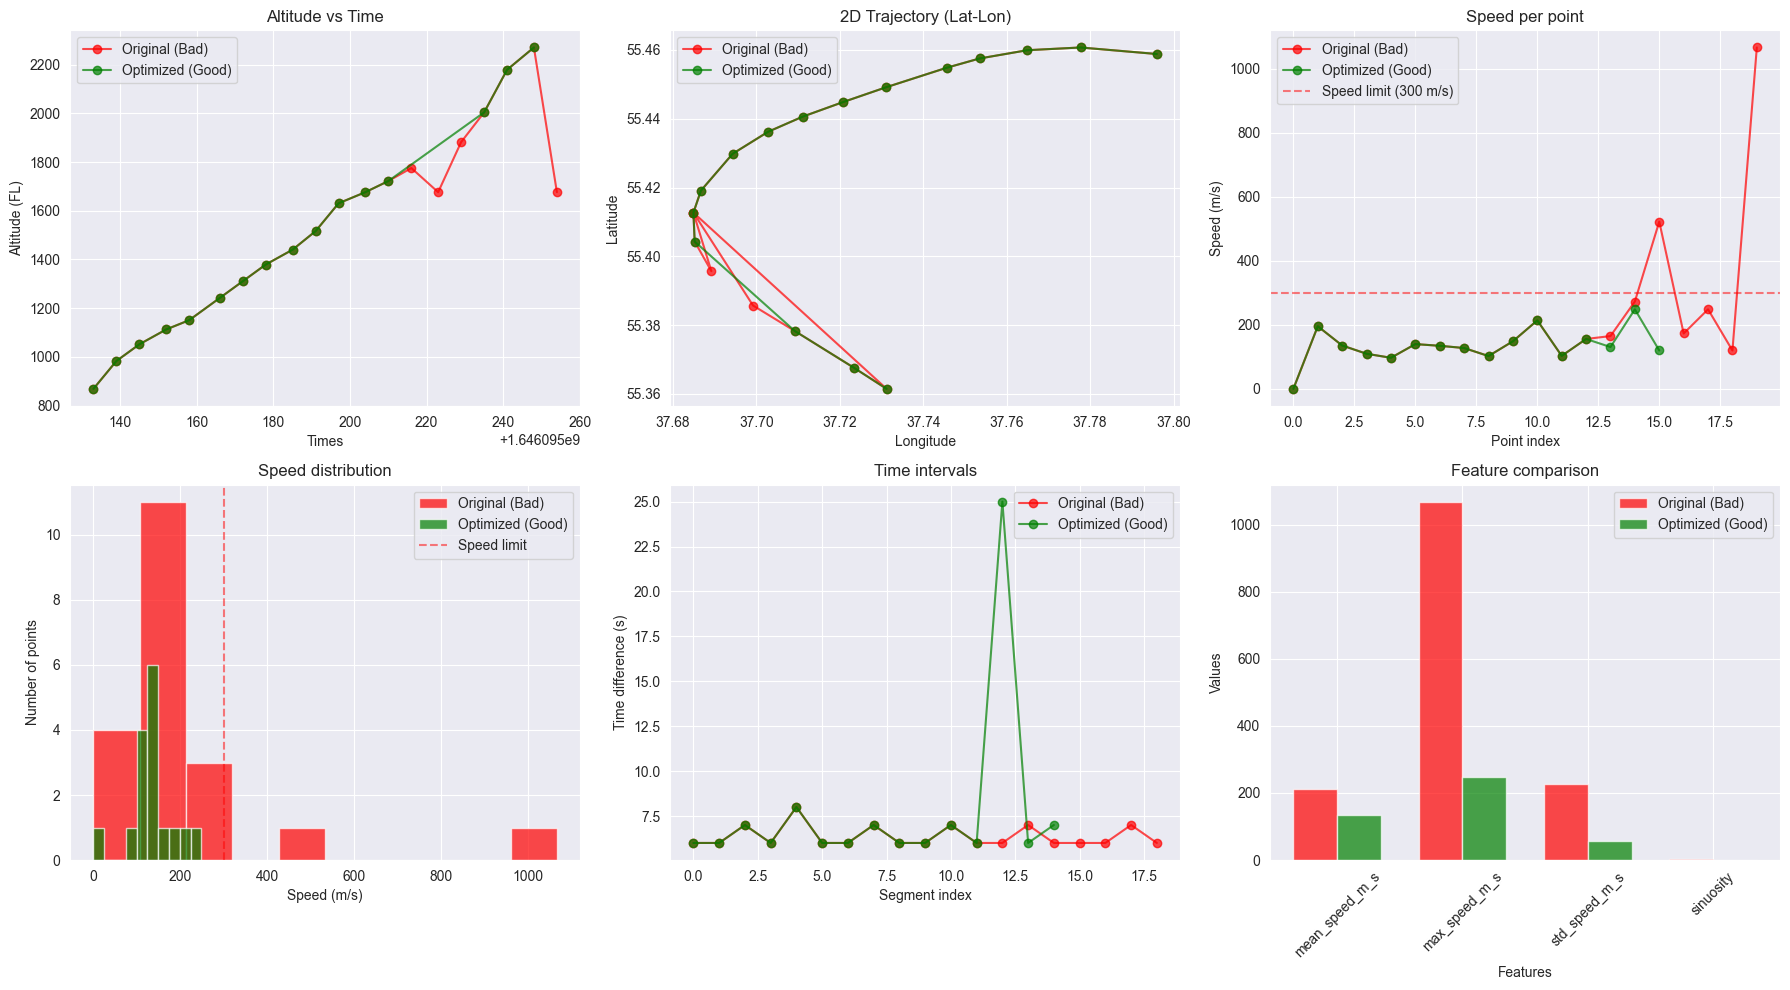

=== COMPARISON STATISTICS ===
Original trajectory: 20 points
Optimized trajectory: 16 points
Removed: 4 points
Maximum speed (original): 1066.72 m/s
Maximum speed (optimized): 248.36 m/s


In [267]:
compare_trajectories_detailed(bad_trajectories[10], optimized_aggressive)

In [289]:
# Evaluating all bad trajectories
def evaluate_optimization_on_all_bad(bad_trajectories_list, model, sample_size=None):

    if sample_size is None:
        sample_size = len(bad_trajectories_list)

    results = []
    successful_optimizations = 0

    print(f"Evaluation of {sample_size} trajectories...")
    print("=" * 60)

    for i in range(sample_size):
        original_traj = bad_trajectories_list[i]

        # Original prediction
        feats_orig = summarize(original_traj)
        feats_orig_filtered = {k: v for k, v in feats_orig.items()
                              if k not in ['frac_zero_speed', 'n_large_alt_jumps']}
        X_orig = pd.DataFrame([feats_orig_filtered])
        pred_orig = model.predict(X_orig)[0]
        proba_orig = model.predict_proba(X_orig)[0]

        # Optimization
        try:
            optimized_traj = optimize_trajectory_aggressive(original_traj)

            # Optimized prediction
            feats_opt = summarize(optimized_traj)
            feats_opt_filtered = {k: v for k, v in feats_opt.items()
                                 if k not in ['frac_zero_speed', 'n_large_alt_jumps']}
            X_opt = pd.DataFrame([feats_opt_filtered])
            pred_opt = model.predict(X_opt)[0]
            proba_opt = model.predict_proba(X_opt)[0]

            success = (pred_orig == 0 and pred_opt == 1)
            if success:
                successful_optimizations += 1

            results.append({
                'traj_index': i,
                'original_points': len(original_traj),
                'optimized_points': len(optimized_traj),
                'points_removed': len(original_traj) - len(optimized_traj),
                'original_pred': pred_orig,
                'optimized_pred': pred_opt,
                'original_proba_bad': proba_orig[0],
                'original_proba_good': proba_orig[1],
                'optimized_proba_bad': proba_opt[0],
                'optimized_proba_good': proba_opt[1],
                'success': success
            })

            if i % 50 == 0:
                print(f"Processed {i}/{sample_size}...")

        except Exception as e:
            # print(f"Error with trajectory {i}: {e}")
            continue

    results_df = pd.DataFrame(results)

    print("\n" + "=" * 60)
    print("EVALUATION RESULTS:")
    print("=" * 60)

    total_tested = len(results_df)
    success_rate = (successful_optimizations / total_tested) * 100

    print(f"Total tested trajectories: {total_tested}")
    print(f"Successfully optimized (from BAD to GOOD): {successful_optimizations}")
    print(f"Optimization success rate: {success_rate:.2f}%")

    # Detailed statistics
    print(f"\nAverage number of points per trajectory:")
    print(f"Original: {results_df['original_points'].mean():.1f}")
    print(f"Optimized: {results_df['optimized_points'].mean():.1f}")
    print(f"Removed: {results_df['points_removed'].mean():.1f}")

    # Confusion matrix-style breakdown
    print(f"\nDETAILED OVERVIEW:")
    stayed_bad = len(results_df[(results_df['original_pred'] == 0) & (results_df['optimized_pred'] == 0)])
    became_good = len(results_df[(results_df['original_pred'] == 0) & (results_df['optimized_pred'] == 1)])
    stayed_good = len(results_df[(results_df['original_pred'] == 1) & (results_df['optimized_pred'] == 1)])
    became_bad = len(results_df[(results_df['original_pred'] == 1) & (results_df['optimized_pred'] == 0)])

    print(f"BAD → BAD: {stayed_bad}")
    print(f"BAD → GOOD: {became_good}")
    print(f"GOOD → GOOD: {stayed_good}")
    print(f"GOOD → BAD: {became_bad}")

    return results_df


In [269]:
 results = evaluate_optimization_on_all_bad(bad_trajectories, rf)

Evaluation of 1000 trajectories...
Processed 0/1000...
Processed 50/1000...
Processed 100/1000...
Processed 150/1000...
Processed 200/1000...
Processed 250/1000...
Processed 300/1000...
Processed 350/1000...
Processed 400/1000...
Processed 450/1000...
Processed 500/1000...
Processed 550/1000...
Processed 600/1000...
Processed 650/1000...
Processed 700/1000...
Processed 750/1000...
Processed 800/1000...
Processed 850/1000...
Processed 900/1000...
Processed 950/1000...

EVALUATION RESULTS:
Total tested trajectories: 1000
Successfully optimized (from BAD to GOOD): 943
Optimization success rate: 94.30%

Average number of points per trajectory:
Original: 20.0
Optimized: 14.9
Removed: 5.1

DETAILED OVERVIEW:
BAD → BAD: 55
BAD → GOOD: 943
GOOD → GOOD: 2
GOOD → BAD: 0


In [270]:
def plot_optimization_results(results_df):

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Optimization success rate
    success_count = results_df['success'].sum()
    fail_count = len(results_df) - success_count
    axes[0].pie([success_count, fail_count],
                  labels=['Successfully\noptimized', 'Unsuccessfully\noptimized'],
                  autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
    axes[0].set_title('Optimization Success Rate')

    # Change in probability for GOOD class
    axes[1].scatter(results_df['original_proba_good'], results_df['optimized_proba_good'],
                     alpha=0.6, c=results_df['success'].map({True: 'green', False: 'red'}))
    axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.3)
    axes[1].set_xlabel('Probability for GOOD (original)')
    axes[1].set_ylabel('Probability for GOOD (optimized)')
    axes[1].set_title('Change in Probability for GOOD Class')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


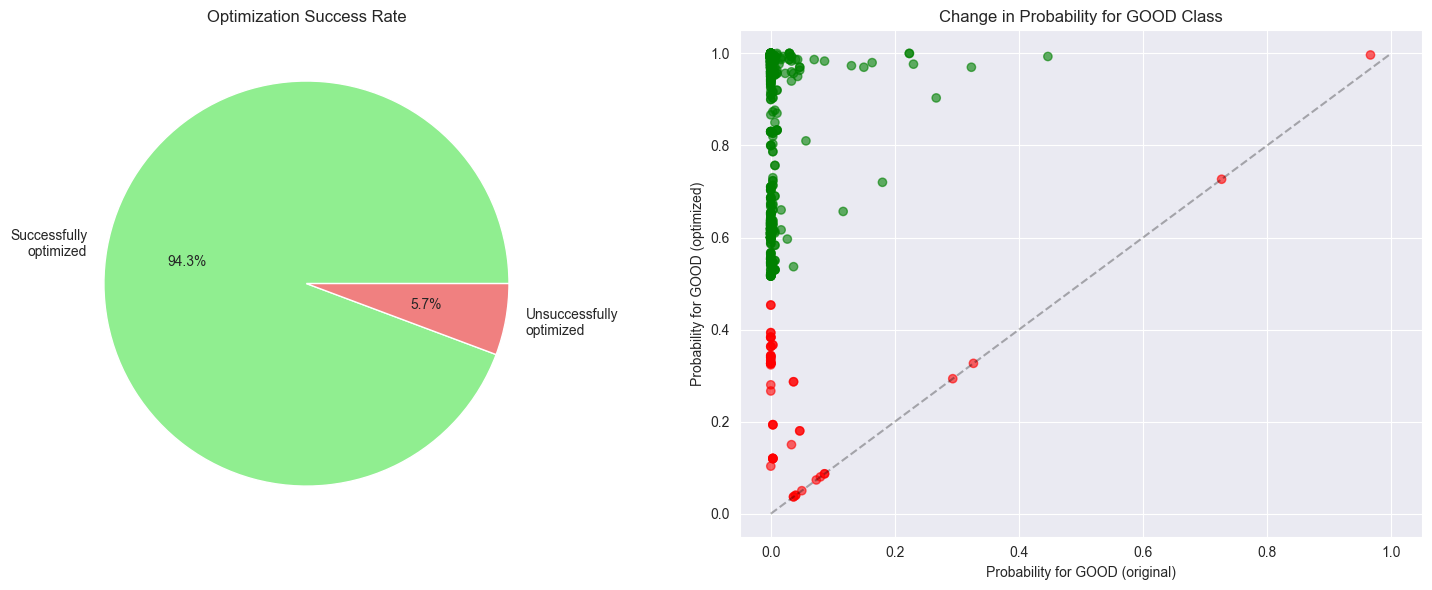

In [271]:
plot_optimization_results(results)

Optimizing based on statistical thresholds from good trajectories

In [272]:
# Avg statistics calculation
def calculate_real_statistics(good_trajectories, bad_trajectories):

    good_features = []
    for traj in good_trajectories:
        try:
            feats = summarize(traj)
            good_features.append(feats)
        except:
            continue

    bad_features = []
    for traj in bad_trajectories:
        try:
            feats = summarize(traj)
            bad_features.append(feats)
        except:
            continue

    df_good = pd.DataFrame(good_features)
    df_bad = pd.DataFrame(bad_features)

    print(f"Analyzed {len(df_good)} good and {len(df_bad)} bad trajectories")

    real_good_stats = {
        'mean_speed_m_s': df_good['mean_speed_m_s'].mean(),
        'std_speed_m_s': df_good['std_speed_m_s'].mean(),
        'max_speed_m_s': df_good['max_speed_m_s'].mean(),
        'mean_vrate': df_good['mean_vrate'].mean(),
        'max_abs_vrate': df_good['max_abs_vrate'].mean(),
        'total_dist_m': df_good['total_dist_m'].mean(),
        'sinuosity': df_good['sinuosity'].mean(),
        'frac_zero_speed': df_good['frac_zero_speed'].mean(),
        'n_large_alt_jumps': df_good['n_large_alt_jumps'].mean()
    }

    real_bad_stats = {
        'mean_speed_m_s': df_bad['mean_speed_m_s'].mean(),
        'std_speed_m_s': df_bad['std_speed_m_s'].mean(),
        'max_speed_m_s': df_bad['max_speed_m_s'].mean(),
        'mean_vrate': df_bad['mean_vrate'].mean(),
        'max_abs_vrate': df_bad['max_abs_vrate'].mean(),
        'total_dist_m': df_bad['total_dist_m'].mean(),
        'sinuosity': df_bad['sinuosity'].mean(),
        'frac_zero_speed': df_bad['frac_zero_speed'].mean(),
        'n_large_alt_jumps': df_bad['n_large_alt_jumps'].mean()
    }

    print("Good trajectories statistics:")
    for key, value in real_good_stats.items():
        print(f"  {key}: {value:.2f}")

    print("\nBad trajectories statistics:")
    for key, value in real_bad_stats.items():
        print(f"  {key}: {value:.2f}")

    return real_good_stats, real_bad_stats


In [273]:
real_good_stats, real_bad_stats = calculate_real_statistics(good_trajectories, bad_trajectories)

Analyzed 1000 good and 1000 bad trajectories
Good trajectories statistics:
  mean_speed_m_s: 108.63
  std_speed_m_s: 53.45
  max_speed_m_s: 227.29
  mean_vrate: 2.61
  max_abs_vrate: 13.84
  total_dist_m: 13837.83
  sinuosity: 1.32
  frac_zero_speed: 0.05
  n_large_alt_jumps: 5.59

Bad trajectories statistics:
  mean_speed_m_s: 479.92
  std_speed_m_s: 808.85
  max_speed_m_s: 2817.68
  mean_vrate: -0.09
  max_abs_vrate: 31.52
  total_dist_m: 59905.96
  sinuosity: 2.72
  frac_zero_speed: 0.05
  n_large_alt_jumps: 4.42


In [274]:
real_good_stats = {
    'mean_speed_m_s': 108.63,
    'std_speed_m_s': 53.45,
    'max_speed_m_s': 227.29,
    'total_dist_m': 13837.83,
    'sinuosity': 1.32
}

real_bad_stats = {
    'mean_speed_m_s': 479.92,
    'std_speed_m_s': 808.85,
    'max_speed_m_s': 2817.68,
    'total_dist_m': 59905.96,
    'sinuosity': 2.72
}

In [290]:
# Optimizing the trajectory using statistical thresholds from good trajectories
def optimize_trajectory_calculated_1(trajectory, good_stats):

    df = pd.DataFrame(trajectory, columns=['timestamp', 'lat', 'lon', 'alt_FL'])

    # print(f"Original: {len(df)} points")

    # Sort and clean
    df = df.sort_values('timestamp').reset_index(drop=True)
    df = df.drop_duplicates(subset=['timestamp'])

    # Removing GPS spikes based on max speed from good trajectories (227.29 m/s)
    df = remove_velocity_outliers(df, max_speed=good_stats['max_speed_m_s'])

    # Removing spatial outliers with statistics
    # Real avg good speed: 108.63 m/s, reasonable jump in 60 seconds = 6.5km
    avg_good_speed = good_stats['mean_speed_m_s']
    reasonable_jump_km = (avg_good_speed * 60) / 1000
    df = remove_spatial_outliers(df, max_jump_km=reasonable_jump_km)

    # Sampling based on good trajectory length (average ~20 points)
    avg_good_points = 20
    if len(df) > avg_good_points * 1.5:
        df = smart_sampling(df, max_points=int(avg_good_points * 1.2))

    # Sinuosity optimization (1.32)
    if len(df) > 8:
        df = optimize_sinuosity(df, max_sinuosity=good_stats['sinuosity'] * 1.2)  # 1.58

    # print(f"Optimized: {len(df)} points")
    return df.values

In [276]:
# Evaluating all trajectories
def evaluate_calculated_optimization_on_all_avg(trajectories_list, model, good_stats, sample_size=None):

    if sample_size is None:
        sample_size = len(trajectories_list)

    results_calc = []
    successful_optimizations = 0

    print(f"Evaluation of {sample_size} trajectories...")
    print("=" * 70)

    for i in range(sample_size):
        original_traj = trajectories_list[i]

        # Original prediction
        feats_orig = summarize(original_traj)
        feats_orig_filtered = {k: v for k, v in feats_orig.items()
                              if k not in ['frac_zero_speed', 'n_large_alt_jumps']}
        X_orig = pd.DataFrame([feats_orig_filtered])
        pred_orig = model.predict(X_orig)[0]
        proba_orig = model.predict_proba(X_orig)[0]

        # Optimization
        try:
            optimized_traj = optimize_trajectory_calculated_1(original_traj, good_stats)

            # Optimized prediction
            feats_opt_c = summarize(optimized_traj)
            feats_opt_filtered = {k: v for k, v in feats_opt_c.items()
                                 if k not in ['frac_zero_speed', 'n_large_alt_jumps']}
            X_opt_c = pd.DataFrame([feats_opt_filtered])
            pred_opt_c = model.predict(X_opt_c)[0]
            proba_opt_c = model.predict_proba(X_opt_c)[0]

            success = (pred_orig == 0 and pred_opt_c == 1)
            if success:
                successful_optimizations += 1

            results_calc.append({
                'traj_index': i,
                'original_points': len(original_traj),
                'optimized_points': len(optimized_traj),
                'points_removed': len(original_traj) - len(optimized_traj),
                'original_pred': pred_orig,
                'optimized_pred': pred_opt_c,
                'original_proba_bad': proba_orig[0],
                'original_proba_good': proba_orig[1],
                'optimized_proba_bad': proba_opt_c[0],
                'optimized_proba_good': proba_opt_c[1],
                'success': success,
                'original_max_speed': feats_orig['max_speed_m_s'],
                'optimized_max_speed': feats_opt_c['max_speed_m_s'],
                'original_total_dist': feats_orig['total_dist_m'],
                'optimized_total_dist': feats_opt_c['total_dist_m']
            })

            if i % 50 == 0:
                print(f"Processed {i}/{sample_size}...")

        except Exception as e:
            # print(f"Error with trajectory {i}: {e}")
            continue

    results_df_c = pd.DataFrame(results_calc)

    print("\n" + "=" * 70)
    print("CALCULATED OPTIMIZATION RESULTS:")
    print("=" * 70)

    total_tested = len(results_df_c)
    success_rate = (successful_optimizations / total_tested) * 100

    print(f"Total tested trajectories: {total_tested}")
    print(f"Successfully optimized: {successful_optimizations}")
    print(f"Optimization success rate: {success_rate:.2f}%")

    # Detailed statistics
    print(f"\nAverage number of points per trajectory:")
    print(f"Original: {results_df_c['original_points'].mean():.1f}")
    print(f"Optimized: {results_df_c['optimized_points'].mean():.1f}")
    print(f"Removed: {results_df_c['points_removed'].mean():.1f}")

    # Confusion matrix-style breakdown
    print(f"\nDETAILED OVERVIEW:")
    stayed_bad = len(results_df_c[(results_df_c['original_pred'] == 0) & (results_df_c['optimized_pred'] == 0)])
    became_good = len(results_df_c[(results_df_c['original_pred'] == 0) & (results_df_c['optimized_pred'] == 1)])
    stayed_good = len(results_df_c[(results_df_c['original_pred'] == 1) & (results_df_c['optimized_pred'] == 1)])
    became_bad = len(results_df_c[(results_df_c['original_pred'] == 1) & (results_df_c['optimized_pred'] == 0)])

    print(f"BAD → BAD: {stayed_bad}")
    print(f"BAD → GOOD: {became_good}")
    print(f"GOOD → GOOD: {stayed_good}")
    print(f"GOOD → BAD: {became_bad}")

    return results_df_c


In [277]:
print("--- AVG OPTIMIZATION ---")
rang_opt = optimize_trajectory_calculated_1(bad_trajectories[10], real_good_stats)

print("\n--- RE-EVALUATION ---")
explain_trajectory(rang_opt, rf)

print("\n--- MODEL PREDICTION ---")
feats_opt = summarize(rang_opt)
feats_filtered = {k: v for k, v in feats_opt.items()
                 if k not in ['frac_zero_speed', 'n_large_alt_jumps']}

X_opt = pd.DataFrame([feats_filtered])
pred_opt = rf.predict(X_opt)[0]
proba_opt = rf.predict_proba(X_opt)[0]

print(f"Predicted class: {'GOOD' if pred_opt == 1 else 'BAD'}")
print(f"Probability: {proba_opt}")

--- AVG OPTIMIZATION ---

--- RE-EVALUATION ---
Trajectory Analysis
-------------------------
Predicted label: GOOD
Trajectory appears smooth and consistent.

--- MODEL PREDICTION ---
Predicted class: GOOD
Probability: [0. 1.]


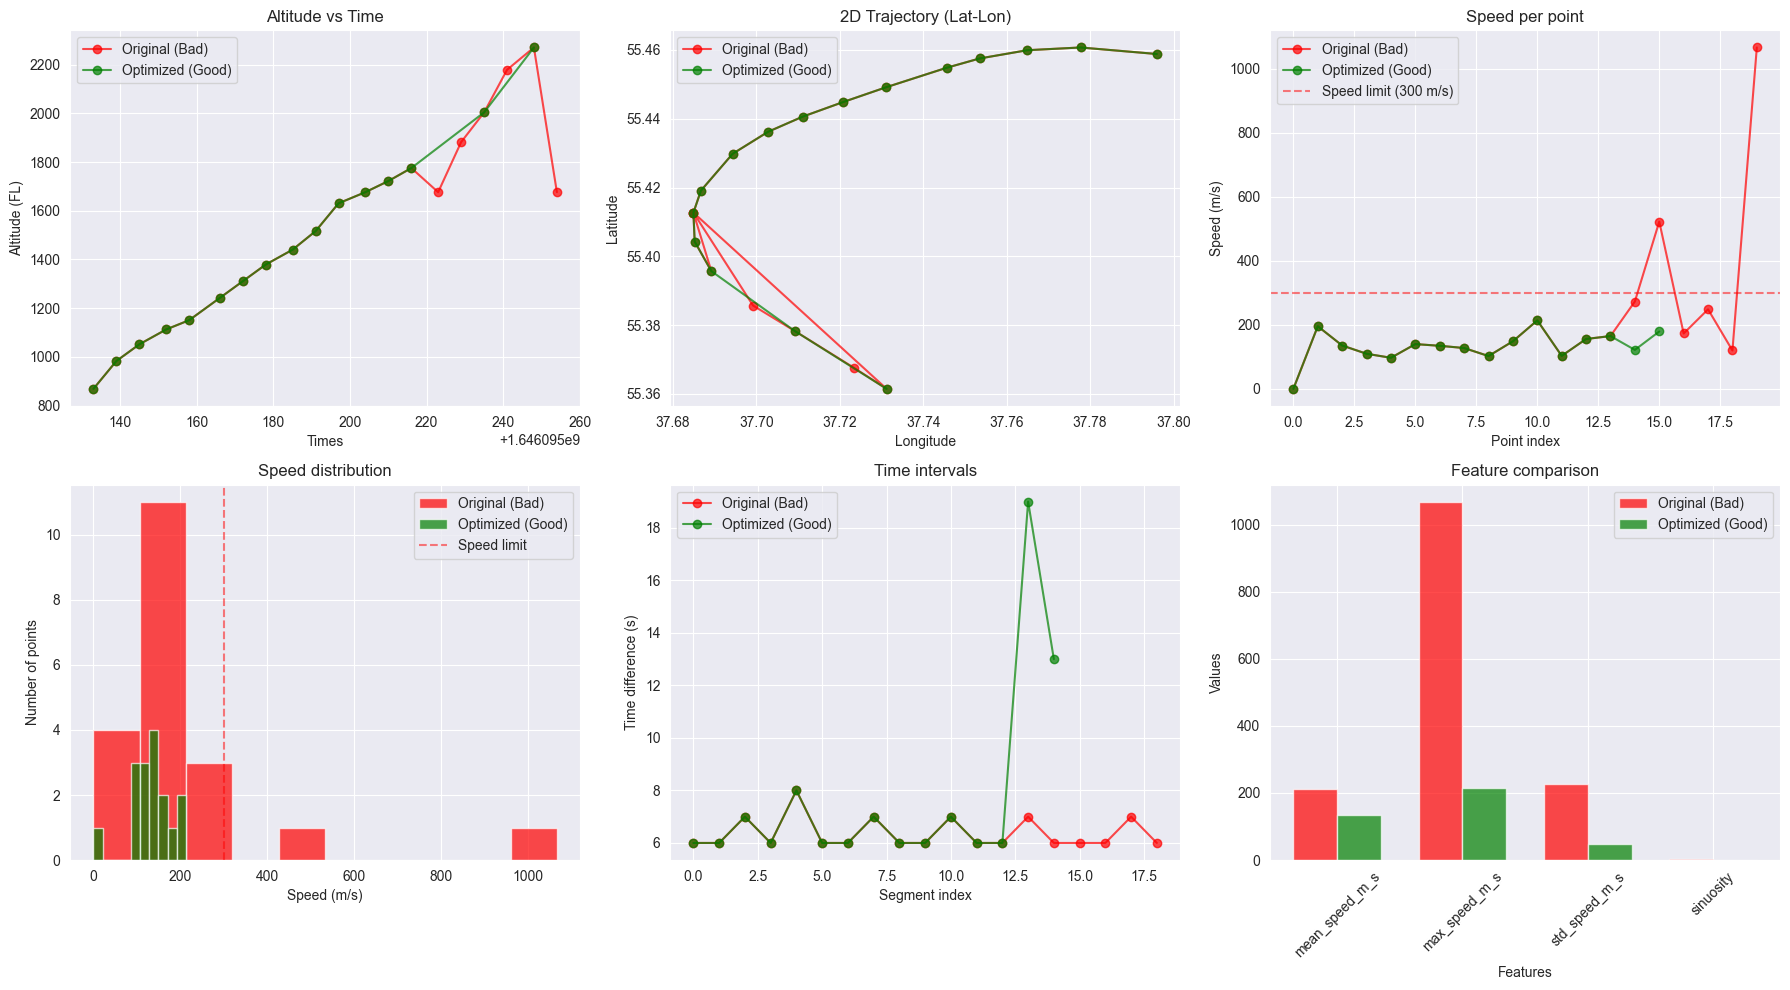

=== COMPARISON STATISTICS ===
Original trajectory: 20 points
Optimized trajectory: 16 points
Removed: 4 points
Maximum speed (original): 1066.72 m/s
Maximum speed (optimized): 213.80 m/s


In [278]:
compare_trajectories_detailed(bad_trajectories[10], rang_opt)

In [279]:
results4 = evaluate_calculated_optimization_on_all_avg(bad_trajectories, rf,real_good_stats)

Evaluation of 1000 trajectories...
Processed 0/1000...
Processed 50/1000...
Processed 100/1000...
Processed 150/1000...
Processed 200/1000...
Processed 250/1000...
Processed 300/1000...
Processed 350/1000...
Processed 400/1000...
Processed 450/1000...
Processed 500/1000...
Processed 550/1000...
Processed 600/1000...
Processed 650/1000...
Processed 700/1000...
Processed 750/1000...
Processed 800/1000...
Processed 850/1000...
Processed 900/1000...
Processed 950/1000...

CALCULATED OPTIMIZATION RESULTS:
Total tested trajectories: 997
Successfully optimized: 975
Optimization success rate: 97.79%

Average number of points per trajectory:
Original: 20.0
Optimized: 11.4
Removed: 8.6

DETAILED OVERVIEW:
BAD → BAD: 20
BAD → GOOD: 975
GOOD → GOOD: 2
GOOD → BAD: 0


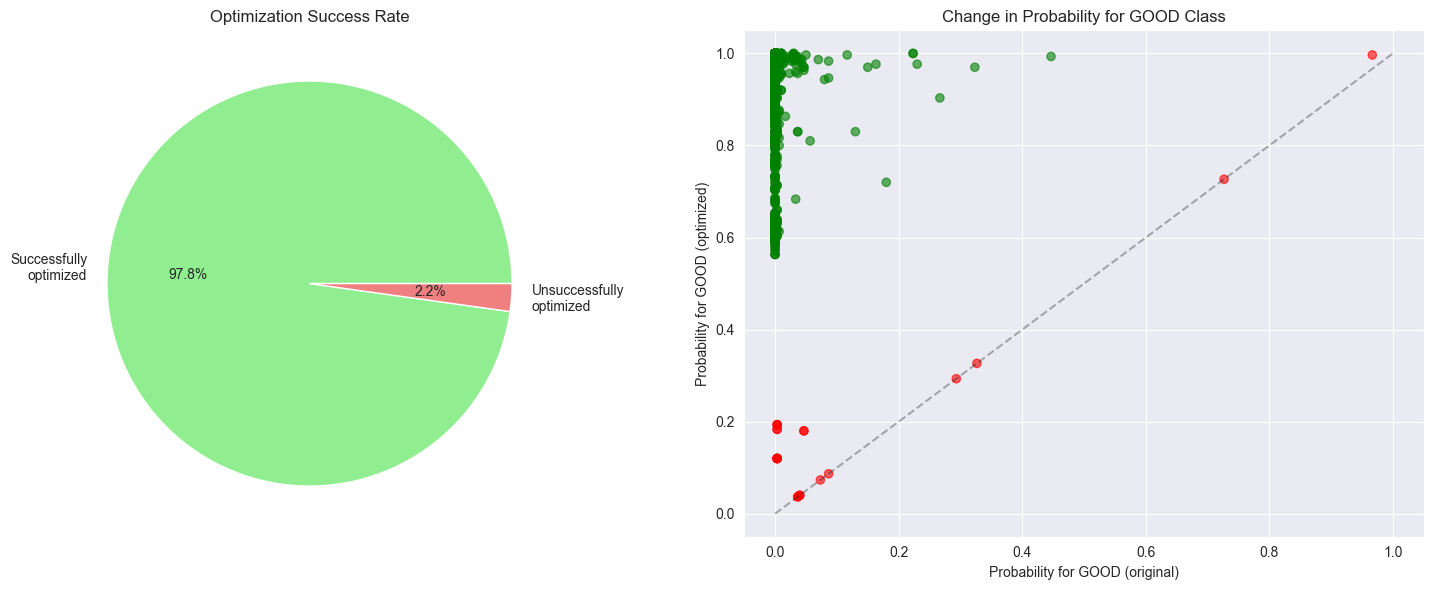

In [280]:
plot_optimization_results(results4)

In [281]:
results5 = evaluate_calculated_optimization_on_all_avg(good_trajectories, rf,real_good_stats)

Evaluation of 1000 trajectories...
Processed 0/1000...
Processed 50/1000...
Processed 100/1000...
Processed 150/1000...
Processed 200/1000...
Processed 250/1000...
Processed 300/1000...
Processed 350/1000...
Processed 400/1000...
Processed 450/1000...
Processed 500/1000...
Processed 550/1000...
Processed 600/1000...
Processed 650/1000...
Processed 700/1000...
Processed 750/1000...
Processed 800/1000...
Processed 850/1000...
Processed 900/1000...
Processed 950/1000...

CALCULATED OPTIMIZATION RESULTS:
Total tested trajectories: 1000
Successfully optimized: 0
Optimization success rate: 0.00%

Average number of points per trajectory:
Original: 20.0
Optimized: 18.8
Removed: 1.2

DETAILED OVERVIEW:
BAD → BAD: 0
BAD → GOOD: 0
GOOD → GOOD: 991
GOOD → BAD: 9


In [282]:
good_to_good = results4[
    (results4['original_pred'] == 1) &
    (results4['optimized_pred'] == 1)
]

print("Trajectories that are GOOD in the bad trajectories:")
print(good_to_good['traj_index'].values)

Trajectories that are GOOD in the bad trajectories:
[162 253]


In [283]:
bad_to_bad = results4[
    (results4['original_pred'] == 0) &
    (results4['optimized_pred'] == 0)
]

print("Trajectories that stayed BAD:")
print(bad_to_bad['traj_index'].values)


Trajectories that stayed BAD:
[ 47  61  65  73  75 206 226 236 386 478 504 557 719 821 875 889 906 931
 959 999]


In [284]:
good_to_bad = results5[
    (results5['original_pred'] == 1) &
    (results5['optimized_pred'] == 0)
]

print("Trajectories that went from GOOD → BAD:")
print(good_to_bad['traj_index'].values)


Trajectories that went from GOOD → BAD:
[ 49 153 333 389 507 750 842 985 989]
